In [11]:
%load_ext autoreload
%autoreload 2
import numpy as np 
from logistic_regression import CustomeLogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import PredefinedSplit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
torch.manual_seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Data 2.2.1

In [12]:
mu = 2.5
sigma = np.identity(2)
posi = np.random.multivariate_normal([mu,0], sigma, 750)
nega = np.random.multivariate_normal([-mu, 0], sigma, 750)
X = np.vstack((posi, nega))
y = np.hstack((np.ones(750), (-1)*np.ones(750)))

#Split the dataset into train, validation, and test set
df_x, df_test, df_y, y_test = train_test_split(X, y, test_size= 250, random_state= 42)
x_train, x_val, y_train, y_val = train_test_split(df_x, df_y, test_size= 250, random_state= 100)

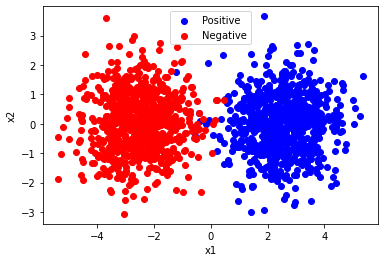

In [13]:
plt.scatter(posi[:, 0], posi[:, 1], c = 'blue', label = 'Positive')
plt.scatter(nega[:, 0], nega[:, 1], c = 'red', label = 'Negative')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()

linear SVM

In [43]:
class Linear_SVM:
    def __init__(self, learning_rate = 0.001, epochs = 200, batch_size = 64, lmda = 0.1):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.lmda = lmda
    
    def fit(self, X, y):
        X = torch.tensor(X, dtype= torch.float32)
        y = torch.tensor(y, dtype = torch.float32)

        num_feature = X.shape[1]
        self.W = torch.randn(num_feature, 1, requires_grad= True, dtype = torch.float32)
        self.b = torch.randn(1, requires_grad= True, dtype = torch.float32)

        optimizer = torch.optim.SGD([self.W, self.b], lr = self.learning_rate)

        for epoch in range(self.epochs):
            dataloader = DataLoader(TensorDataset(X,y), batch_size= self.batch_size, shuffle= True)
            for batch_X, batch_y in dataloader:
                # torch.clamp() choose each element to be larger than 0, otherwise 0 
                hinge_loss = torch.mean(torch.clamp(1- batch_y * (batch_X @ self.W + self.b), min=0))
                reg_loss = 0.5 * self.lmda * torch.sum(self.W ** 2) #regularization loss
                loss = hinge_loss + reg_loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    
    def predict(self, X):
        X = torch.tensor(X, dtype = torch.float32)
        return torch.sign(X @ self.W  +self.b).detach().numpy()
    
    def score(self, X , y):
        # torch.tensor(y, dtype= torch.float32) makes y into a tensor with size y.shape which is (750, )
        y = torch.tensor(y, dtype= torch.float32).unsqueeze(1)
        y_pred = torch.tensor(self.predict(X), dtype= torch.float32)
        return torch.mean((y_pred == y).float())


In [15]:
class KernelSVM(Linear_SVM):
    def __init__(self, kernel = 'linear', degree = 3, gamma = None, coef0 = 0, **kwargs):
        super().__init__(**kwargs)
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
    
    def compute_kernel(self, X1, X2):
        if self.kernel == 'linear':
            return X1 @ X2.T
        
        elif self.kernel == 'rbf':
            gamma = self.gamma or 1/X1.shape[1]
            pairwise_sq_dists = torch.sum(X1 **2, dim=1, keepdim= True) - 2*X1@X2.T + torch.sum(X2 ** 2, dim = 1)
            return torch.exp(-gamma * pairwise_sq_dists)
        
        elif self.kernel == 'polynomial':
            return (X1@X2.T * self.gamma + self.coef0) ** self.degree

    def fit(self, X, y):
        self.X_train = torch.tensor(X, dtype= torch.float32)
        self.y_train = torch.tensor(y, dtype = torch.float32)
        K = self.compute_kernel(self.X_train, self.X_train)
        super().fit(K, y)
    
    def predict(self, X):
        X = torch.tensor(X, dtype = torch.float32)
        K = self.compute_kernel(X, self.X_train)
        return super().predict(K)

In [33]:
def plot_decision_boundary(clf, X, y, title):
    h = .02 #step size in the mesh
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    if isinstance(Z, list):
        Z = np.array(Z)
    Z = Z.reshape(xx.shape)

    #Plot 
    plt.figure()
    plt.pcolormesh(xx, yy, Z,  cmap= cmap_light)

    #Plot the scatter points
    plt.scatter(X[:, 0], X[:, 1], c = y, cmap = cmap_bold, edgecolors='k', s= 20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.show()

Best Linear SVM


In [17]:
def best_linear(x_train, y_train, x_val, y_val, x_test, y_test):
    best_lr = None
    best_epochs = None
    best_lambda = None
    best_batch = None
    best_model = None
    lrs = np.linspace(0.001, 0.081, 4)
    epochs_list = np.linspace(50, 250, 2)
    lambdas = np.linspace(0.01, 0.21, 4)
    batch_sizes = [32, 64, 128]
    best_score = -1
    for lr in lrs:
        for epo in epochs_list:
            for ld in lambdas:
                for batch in batch_sizes:
                    linear_svm_model = Linear_SVM(lr, int(epo), batch, ld)
                    linear_svm_model.fit(x_train, y_train)
                    score = linear_svm_model.score(x_val, y_val).item()
                    if score > best_score:
                        best_score = score
                        best_lr = lr
                        best_epochs = epo
                        best_lambda = ld
                        best_batch = batch
                        best_model = linear_svm_model
                    if best_score == 1:
                        break
    #score on test 
    print(f'highest test score is {best_model.score(x_test, y_test).item()} with {best_lr} lr, {best_lambda} lambda, {best_batch} best size, and {best_epochs} epochs')
    return best_model.score(x_test, y_test).item(), best_model

In [23]:
best_linear_acc, best_linear_model = best_linear(x_train, y_train, x_val, y_val, df_test, y_test)

highest test score is 0.9879999756813049 with 0.001 lr, 0.07666666666666666 lambda, 64 best size, and 50.0 epochs


<ipython-input-26-3c7d44cadfd0>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z,  cmap= cmap_light)


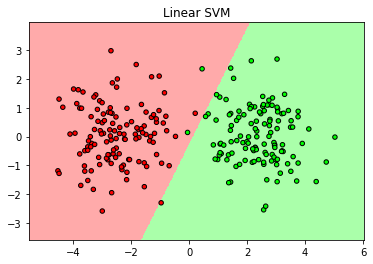

In [27]:
plot_decision_boundary(best_linear_model, df_test, y_test, 'Linear SVM')

Best SVM kernel

In [28]:
def best_svm_kernel(x_train, y_train, x_val, y_val, x_test, y_test, kernel):
    best_score = -1
    best_model = None

    lrs = np.linspace(0.001, 0.041, 2)
    epochs_list = [100, 200, 400, 700]
    lambdas = np.linspace(0.01, 0.11, 2)
    batch_sizes = [32, 64, 128]
    gammas =  [0.001, 0.1, 1, 10, 100]
    degrees = [2,3,4,5]
    coefs = [0, 1, 2, 3]
    for lr in lrs:
        for epo in epochs_list:
            for ld in lambdas:
                for batch in batch_sizes:
                    if kernel == 'linear':
                        kernelsvm_model = KernelSVM(learning_rate = lr, epochs = int(epo), batch_size = batch, lmda = ld, kernel= kernel)
                        kernelsvm_model.fit(x_train, y_train)
                        score_kern = kernelsvm_model.score(x_val, y_val).item()
                        if score_kern > best_score:
                            best_score = score_kern
                            best_model = kernelsvm_model
                    elif kernel =='rbf':
                        for gamma in gammas:
                            kernelsvm_model = KernelSVM(learning_rate = lr, epochs = int(epo), batch_size = batch, lmda = ld, gamma= gamma, kernel= kernel)
                            kernelsvm_model.fit(x_train, y_train)
                            score_kern = kernelsvm_model.score(x_val, y_val).item()
                            if score_kern > best_score:
                                best_score = score_kern
                                best_model = kernelsvm_model
                    elif kernel == 'polynomial':
                        for gamma in gammas:
                            for coef in coefs:
                                for degree in degrees:
                                    kernelsvm_model = KernelSVM(learning_rate = lr, epochs = int(epo), batch_size = batch, lmda = ld, gamma= gamma, degree= degree, coef0= coef, kernel= kernel)
                                    kernelsvm_model.fit(x_train, y_train)
                                    score_kern = kernelsvm_model.score(x_val, y_val).item()
                                    if score_kern > best_score:
                                        best_score = score_kern
                                        best_model = kernelsvm_model
                            
    return best_model.score(x_test, y_test), best_model

logistic regression

In [29]:
def logi_reg(x_train, y_train, x_val, y_val, x_test, y_test):
    best_epoch_lr = None
    best_lr_lr = None
    best_model = None
    best_accuracy = -1
    epochs = [100, 150, 300, 600, 800]
    learning_rates = np.linspace(0.001, 0.1, 10)
    for epoch in epochs:
        for lr in learning_rates:
            lr_model = CustomeLogisticRegression(learning_rate = lr)
            lr_model.fit(x_train, y_train, epoch = epoch)
            accuracy = lr_model.accuracy(y_val, x_val)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_epoch_lr = epoch
                best_lr_lr = lr
                best_model = lr_model
    print(f'{best_model.accuracy(y_test, x_test)} with learning rate {best_lr_lr} and {best_epoch_lr} epochs')
    return best_accuracy, best_model

0.992 with learning rate 0.001 and 100 epochs


<ipython-input-33-eb8d1131e534>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z,  cmap= cmap_light)


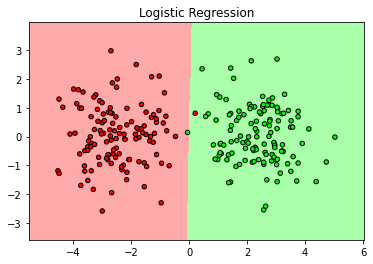

In [34]:
_, lr_model = logi_reg(x_train, y_train, x_val, y_val, df_test, y_test)
plot_decision_boundary(lr_model, df_test, y_test, 'Logistic Regression')

Knn vs Naive Bayes Classifiers

In [35]:
X_combined = np.vstack((x_train, x_val))
y_combined = np.hstack((y_train, y_val))
# Create predefinded 
test_fold = np.concatenate([
    np.full(x_train.shape[0], -1),
    np.zeros(x_val.shape[0])
])
predefined_split = PredefinedSplit(test_fold)

In [36]:
#Knn Classifiers
def knn(X_combined, y_combined, x_test, y_test, split):
    knn = KNeighborsClassifier()
    knn_grid = {'n_neighbors': np.arange(1, 30)}
    knn_grid_search = GridSearchCV(knn, knn_grid, cv = split)
    knn_grid_search.fit(X_combined, y_combined)

    best_k = knn_grid_search.best_estimator_
    knn_accuracy = best_k.score(x_test, y_test)
    print(knn_accuracy)
    return knn_accuracy, best_k

In [38]:
accuracy_k, best_k = knn(X_combined, y_combined, df_test, y_test, predefined_split)
accuracy_k

c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

0.992


c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

0.992

c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
<ipython-input-33-eb8d1131e534>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z,  cmap= cmap_light)


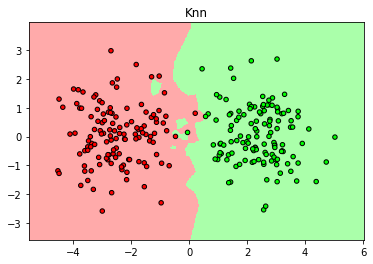

In [48]:
plot_decision_boundary(best_k, df_test, y_test, 'Knn')

In [40]:
#Naive Bayes Classifiers
def NB_classifier(X_combined, y_combined, x_test, y_test):
    nb = GaussianNB()
    nb_param_grid = {'var_smoothing': np.logspace(-10, -1, 10)}
    nb_best = GridSearchCV(nb, nb_param_grid, cv = predefined_split)
    nb_best.fit(X_combined, y_combined)
    nb_accuracy = nb_best.score(x_test, y_test)
    print(nb_accuracy)
    return nb_accuracy, nb_best

0.992


<ipython-input-33-eb8d1131e534>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z,  cmap= cmap_light)


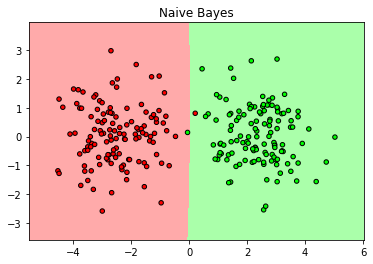

In [49]:
_, nb_best = NB_classifier(X_combined, y_combined, df_test, y_test)
plot_decision_boundary(nb_best, df_test, y_test, 'Naive Bayes')

Data 2.1.2

In [45]:
mus = np.linspace(1, 2.4, 8)
sigma = np.identity(2)

linear_acc_list = []
knn_acc_list = []
lr_acc_list = []
naive_acc_list = []

for mean in mus:
    posi = np.random.multivariate_normal([mean,0], sigma, 750)
    nega = np.random.multivariate_normal([-mean, 0], sigma, 750)
    X = np.vstack((posi, nega))
    y = np.hstack((np.ones(750), (-1)*np.ones(750)))

    #Split the dataset into train, validation, and test set
    df_x, x_test, df_y, y_test = train_test_split(X, y, test_size= 250, random_state= 42)
    x_train, x_val, y_train, y_val = train_test_split(df_x, df_y, test_size= 250, random_state= 100)

    X_combined = np.vstack((x_train, x_val))
    y_combined = np.hstack((y_train, y_val))
    # Create predefinded 
    test_fold = np.concatenate([
        np.full(x_train.shape[0], -1),
        np.zeros(x_val.shape[0])
    ])
    predefined_split = PredefinedSplit(test_fold)

    acc_lr, _ = logi_reg(x_train, y_train, x_val, y_val, x_test, y_test)
    acc_linear, _ = best_linear(x_train, y_train, x_val, y_val, x_test, y_test)
    acc_knn, _ = knn(X_combined, y_combined, x_test, y_test, predefined_split)
    acc_naive, _ = NB_classifier(X_combined, y_combined, x_test, y_test)

    linear_acc_list.append(acc_linear)
    knn_acc_list.append(acc_knn)
    lr_acc_list.append(acc_lr)
    naive_acc_list.append(acc_naive)

0.852 with learning rate 0.001 and 100 epochs
highest test score is 0.8640000224113464 with 0.081 lr, 0.01 lambda, 64 best size, and 50.0 epochs


c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

0.82
0.848
0.88 with learning rate 0.001 and 100 epochs
highest test score is 0.871999979019165 with 0.001 lr, 0.14333333333333334 lambda, 64 best size, and 250.0 epochs


c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

0.872
0.872
0.928 with learning rate 0.001 and 100 epochs
highest test score is 0.9279999732971191 with 0.02766666666666667 lr, 0.07666666666666666 lambda, 32 best size, and 50.0 epochs


c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

0.908
0.928
0.952 with learning rate 0.001 and 100 epochs
highest test score is 0.9440000057220459 with 0.02766666666666667 lr, 0.01 lambda, 32 best size, and 250.0 epochs


c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

0.952
0.956
0.952 with learning rate 0.001 and 100 epochs
highest test score is 0.9639999866485596 with 0.081 lr, 0.14333333333333334 lambda, 32 best size, and 50.0 epochs


c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

0.948
0.956
0.98 with learning rate 0.001 and 100 epochs
highest test score is 0.9359999895095825 with 0.02766666666666667 lr, 0.14333333333333334 lambda, 64 best size, and 50.0 epochs


c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

0.98
0.976
0.976 with learning rate 0.001 and 100 epochs
highest test score is 0.9760000109672546 with 0.02766666666666667 lr, 0.01 lambda, 32 best size, and 250.0 epochs


c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

0.98
0.98
0.988 with learning rate 0.001 and 100 epochs
highest test score is 0.9599999785423279 with 0.001 lr, 0.14333333333333334 lambda, 128 best size, and 250.0 epochs


c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

0.972
0.984


c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [52]:
print(linear_acc_list) 
print(knn_acc_list) 
print(lr_acc_list) 
print(naive_acc_list) 

[0.8640000224113464, 0.871999979019165, 0.9279999732971191, 0.9440000057220459, 0.9639999866485596, 0.9359999895095825, 0.9760000109672546, 0.9599999785423279]
[0.82, 0.872, 0.908, 0.952, 0.948, 0.98, 0.98, 0.972]
[0.824, 0.888, 0.908, 0.956, 0.952, 0.98, 0.976, 0.996]
[0.848, 0.872, 0.928, 0.956, 0.956, 0.976, 0.98, 0.984]


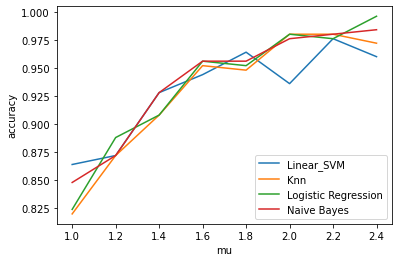

In [51]:
fig, ax = plt.subplots()
ax.plot(mus, linear_acc_list, label = 'Linear_SVM')
ax.plot(mus, knn_acc_list, label = 'Knn')
ax.plot(mus, lr_acc_list, label = 'Logistic Regression')
ax.plot(mus, naive_acc_list, label = 'Naive Bayes')
ax.set_xlabel('mu')
ax.set_ylabel('accuracy')
plt.legend()